In [16]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib
from numpy import linalg as LA
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
import torch.optim as optim
from PIL import Image
import os
from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
class gaussian_sample_layer(nn.Module):

    def __init__(self, latent_dim):
        super(gaussian_sample_layer, self).__init__()
        self.latent_dim = latent_dim
        self.L = 1
        
    def forward(self, mu, sigma):
        epsilon_dist = torch.distributions.MultivariateNormal(torch.zeros(self.latent_dim),torch.eye(self.latent_dim))
        epsilon = epsilon_dist.sample((self.L,))
        epsilon = torch.sum(epsilon, dim=0) / self.L
        a = mu + epsilon * sigma
        return a

In [3]:
class variational_autoencoder(torch.nn.Module):

    def __init__(self):
        super(variational_autoencoder, self).__init__()
        input_size = 784
        output_size = 784
        self.latent_dim = 2
        self.mlp1 = nn.Linear(input_size, 128)
        self.mu = nn.Linear(128, self.latent_dim)
        self.sigma = nn.Linear(128, self.latent_dim)
        self.gaussian = gaussian_sample_layer(self.latent_dim)
        self.mlp4 = nn.Linear(self.latent_dim, 128)
        self.out = nn.Linear(128, output_size)
        self.batch_size = 8

    def forward(self, x):
        h1 = F.sigmoid(self.mlp1(x))
        mu = F.sigmoid(self.mu(h1))
        sigma = F.sigmoid(self.sigma(h1))
        z = self.gaussian(mu, sigma)
        h4 = F.tanh(self.mlp4(z))
        y_hat = F.relu(self.out(h4))
        return y_hat, mu, sigma
    
    def loss(self, x, y, beta=0.0001):
        y_hat, mu, sigma = self.forward(x)
        c = nn.MSELoss()
        l = c(y_hat, y) - beta * 1/2 * torch.sum(1 + torch.log(sigma**2) - mu**2 - sigma**2)
        return l
    
    def decoder(self, x):
        f = F.relu(self.out(F.tanh(self.mlp4(x))))
        return f

In [4]:
vae = variational_autoencoder()
optimizer = optim.Adam(vae.parameters(), lr=3e-4)

In [5]:
batch_size = 8
train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
trainset = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)

In [6]:
for epoch in range(100):
    cnt = 0
    l = 0
    for data in trainset:
        data = data[0].squeeze()
        x = torch.reshape(data, (batch_size, 784))
        y = x.clone()
        optimizer.zero_grad()
        y_hat, _, _ = vae(x)
        loss = vae.loss(x, y)
        loss.backward()
        optimizer.step()
        l += loss
        cnt += 1
    print(l)
    '''if cnt % 600 == 0:
            cnt = 0
            print(l / 600)
            l = 0'''

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


tensor(527.0259, grad_fn=<AddBackward0>)
tensor(513.3351, grad_fn=<AddBackward0>)
tensor(505.1981, grad_fn=<AddBackward0>)
tensor(497.6111, grad_fn=<AddBackward0>)
tensor(491.8896, grad_fn=<AddBackward0>)
tensor(484.8414, grad_fn=<AddBackward0>)
tensor(478.0993, grad_fn=<AddBackward0>)
tensor(469.7633, grad_fn=<AddBackward0>)
tensor(463.6494, grad_fn=<AddBackward0>)
tensor(461.0927, grad_fn=<AddBackward0>)
tensor(458.6511, grad_fn=<AddBackward0>)
tensor(455.5998, grad_fn=<AddBackward0>)
tensor(449.6520, grad_fn=<AddBackward0>)
tensor(444.5571, grad_fn=<AddBackward0>)
tensor(441.4860, grad_fn=<AddBackward0>)
tensor(438.1224, grad_fn=<AddBackward0>)
tensor(434.2981, grad_fn=<AddBackward0>)
tensor(431.7606, grad_fn=<AddBackward0>)
tensor(429.4359, grad_fn=<AddBackward0>)
tensor(427.5029, grad_fn=<AddBackward0>)
tensor(424.6208, grad_fn=<AddBackward0>)
tensor(423.1415, grad_fn=<AddBackward0>)
tensor(420.3769, grad_fn=<AddBackward0>)
tensor(419.4478, grad_fn=<AddBackward0>)
tensor(418.0825,

In [7]:
os.makedirs("model", exist_ok=True)
torch.save(vae.state_dict(), './model/vae.pt')

In [8]:
test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))
testset = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True)

In [9]:
results = []
cnt = 0
os.makedirs("img", exist_ok=True)
for test in testset:
    data = test[0].squeeze()
    x = torch.reshape(data, (batch_size, 784))
    out = vae(x)[0].detach().numpy()
    cnt += 1
    for i in range(data.shape[0]):
        plt.imsave('./img/' + str(cnt) + str(i) + 'org.png', data[i], cmap='gray')
        plt.imsave('./img/' + str(cnt) + str(i) + 'recovered.png', out[i].reshape(28, 28), cmap='gray')

In [10]:
weights = []
for w in vae.parameters():
    weights.append(w)
weights = np.array(weights)

In [11]:
os.makedirs("generated", exist_ok=True)
for i in range(1000):
    dist = torch.distributions.MultivariateNormal(torch.zeros(2),torch.eye(2))
    z = dist.sample()
    plt.imsave('./generated/' + str(i)+'.png', vae.decoder(z).detach().numpy().reshape(28, 28), cmap='gray')

In [20]:
steps = 20
x = np.linspace(0, 1, num=steps)
y = np.linspace(0, 1, num=steps)
z = []
for xval in x:
    for yval in y:
        z.append((xval, yval))
z = np.array(z)

In [13]:
os.makedirs("grid", exist_ok=True)
cnt = 0
for pair in z:
    cnt += 1
    plt.imsave('./grid/' + str(cnt)+'.png', vae.decoder(torch.from_numpy(pair).float()).detach().numpy().reshape(28, 28), cmap='gray')

In [21]:
imgs = []
for pair in z:
    cnt += 1
    imgs.append(vae.decoder(torch.from_numpy(pair).float()).detach().numpy().reshape(28, 28))

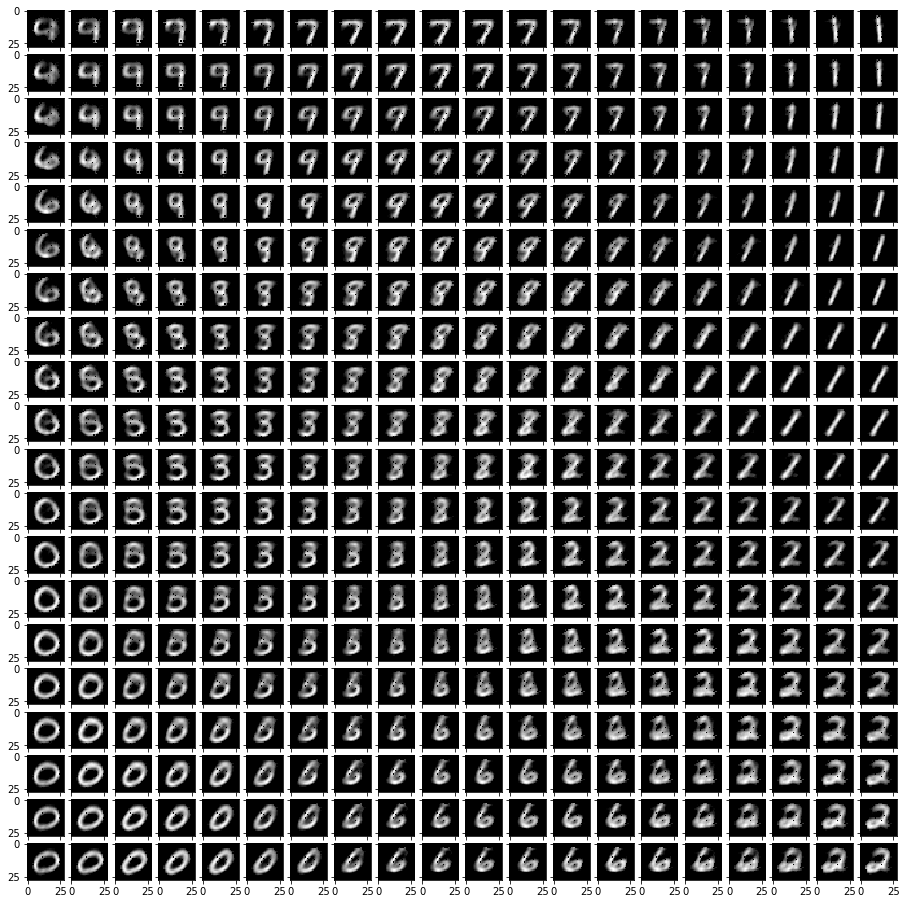

In [23]:
fig = plt.figure(figsize=(16, 16.))
grid = ImageGrid(fig, 111, nrows_ncols=(steps, steps), axes_pad=0.1,)

for ax, im in zip(grid, imgs):
    ax.imshow(im, cmap='gray')